# Introduction

* 주가는 관성의 성격을 가지고 있어 추세를 지속하려하며 파동과 사이클을 반복하려는 속성이 있다. 따라서 주가의 추세를 읽으면 근미래의 주가를 예측할 수 있다. 주식의 이러한 특성을 이용하기 위해 DTW(Dynamic Time Warping) 즉,두 개의 시간적 순서가 있는 벡터 간의 유사도를 평가하는 기법을 이용하여 두 주식 시계열 데이터의 차이를 확인 할 수 있다.  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import dtw
from sklearn.preprocessing import MinMaxScaler
yf.pdr_override()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Importing stock data that possibly benchmark Samsung Electronic stock

In [2]:
se = pdr.get_data_yahoo('005930.KS',start = '2010-01-01',end = '2022-09-14')
kospi = pdr.get_data_yahoo('^KS11',start = '2010-01-01',end = '2022-09-14')
sp500 = pdr.get_data_yahoo('^GSPC',start = '2010-01-01',end = '2022-09-14')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
se.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12810.789062,11950800
2010-01-05,16520.0,16580.0,16300.0,16440.0,13016.647461,27925850
2010-01-06,16580.0,16820.0,16520.0,16820.0,13317.519531,22948850
2010-01-07,16820.0,16820.0,16260.0,16260.0,12874.126953,22107950
2010-01-08,16400.0,16420.0,16120.0,16420.0,13000.815430,14777550


In [4]:
kospi.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500
2010-01-05,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900
2010-01-06,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000
2010-01-07,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400
2010-01-08,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000


In [5]:
sp500.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000


setting target value for stock data

In [6]:
def getMid_price(df):
    high = df.High
    low = df.Low
    mid = (high+low) / 2.0
    return mid

In [7]:
se['Mid'] = getMid_price(se)
kospi['Mid'] = getMid_price(kospi)
sp500['Mid'] = getMid_price(sp500)
se['Tomorrow'] = se['Close'].shift(-1)
kospi['Tomorrow'] = kospi['Close'].shift(-1)
sp500['Tomorrow'] = sp500['Close'].shift(-1)

se['Target'] = (se['Tomorrow'] > se['Close']).astype(int)
kospi['Target'] = (kospi['Tomorrow'] > kospi['Close']).astype(int)
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)
order = ['Open','High','Mid','Low','Close','Adj Close','Volume','Tomorrow','Target']
se = se[order]
kospi = kospi[order]
sp500 = sp500[order]

In [8]:
se

,Open,High,Mid,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,,
2010-01-04,16060.0,16180.0,16090.0,16000.0,16180.0,12810.789062,11950800,16440.0,1
2010-01-05,16520.0,16580.0,16440.0,16300.0,16440.0,13016.647461,27925850,16820.0,1
2010-01-06,16580.0,16820.0,16670.0,16520.0,16820.0,13317.519531,22948850,16260.0,0
2010-01-07,16820.0,16820.0,16540.0,16260.0,16260.0,12874.126953,22107950,16420.0,1
2010-01-08,16400.0,16420.0,16270.0,16120.0,16420.0,13000.815430,14777550,15940.0,0
...,...,...,...,...,...,...,...,...,...
2022-09-05,57400.0,57800.0,57300.0,56800.0,57100.0,57100.000000,11425977,57100.0,0
2022-09-06,57200.0,57600.0,57250.0,56900.0,57100.0,57100.000000,7503086,56000.0,0
2022-09-07,56700.0,56700.0,56300.0,55900.0,56000.0,56000.000000,17384854,55600.0,0


In [9]:
kospi

,Open,High,Mid,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,,
2010-01-04,1681.709961,1696.140015,1688.924988,1681.709961,1696.140015,1696.140015,296500,1690.619995,0
2010-01-05,1701.619995,1702.390015,1694.419983,1686.449951,1690.619995,1690.619995,408900,1705.319946,1
2010-01-06,1697.880005,1706.890015,1701.494995,1696.099976,1705.319946,1705.319946,426000,1683.449951,0
2010-01-07,1702.920044,1707.900024,1695.674988,1683.449951,1683.449951,1683.449951,462400,1695.260010,1
2010-01-08,1694.060059,1695.260010,1682.049988,1668.839966,1695.260010,1695.260010,380000,1694.119995,0
...,...,...,...,...,...,...,...,...,...
2022-09-05,2410.070068,2424.770020,2408.699951,2392.629883,2403.679932,2403.679932,354700,2410.020020,1
2022-09-06,2409.719971,2422.530029,2410.895020,2399.260010,2410.020020,2410.020020,294100,2376.459961,0
2022-09-07,2395.659912,2398.399902,2381.875000,2365.350098,2376.459961,2376.459961,377900,2384.280029,1


In [10]:
sp500

,Open,High,Mid,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,,
2009-12-31,1126.599976,1127.640015,1121.225037,1114.810059,1115.099976,1115.099976,2076990000,1132.989990,1
2010-01-04,1116.560059,1133.869995,1125.215027,1116.560059,1132.989990,1132.989990,3991400000,1136.520020,1
2010-01-05,1132.660034,1136.630005,1133.145020,1129.660034,1136.520020,1136.520020,2491020000,1137.140015,1
2010-01-06,1135.709961,1139.189941,1136.569946,1133.949951,1137.140015,1137.140015,4972660000,1141.689941,1
2010-01-07,1136.270020,1142.459961,1136.889954,1131.319946,1141.689941,1141.689941,5270680000,1144.979980,1
...,...,...,...,...,...,...,...,...,...
2022-09-07,3909.429932,3987.889893,3946.959961,3906.030029,3979.870117,3979.870117,3890320000,4006.179932,1
2022-09-08,3959.939941,4010.500000,3977.655029,3944.810059,4006.179932,4006.179932,3966850000,4067.360107,1
2022-09-09,4022.939941,4076.810059,4049.875000,4022.939941,4067.360107,4067.360107,3901940000,4110.410156,1


overall visualization of indexes and stocks

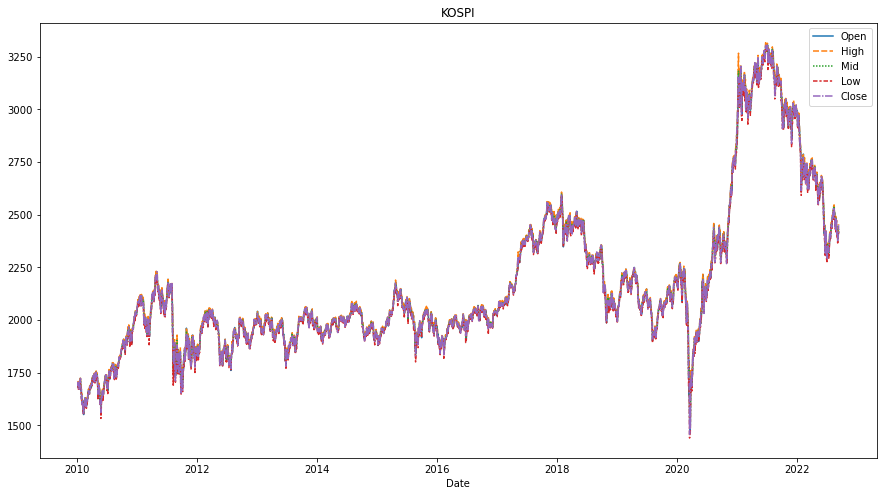

In [11]:
plt.figure(figsize = (15,8))
sns.lineplot(data = kospi[['Open', 'High','Mid','Low','Close']]).set(title = 'KOSPI')
plt.show()

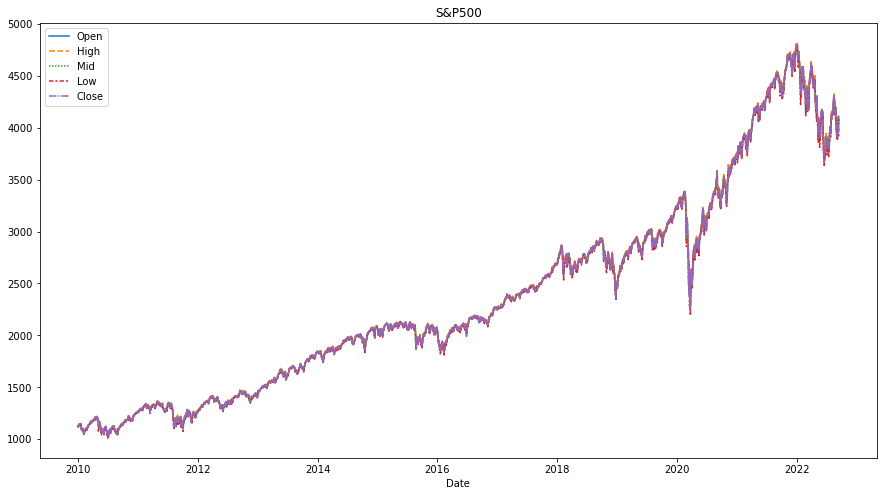

In [12]:
plt.figure(figsize = (15,8))
sns.lineplot(data = sp500[['Open', 'High','Mid','Low','Close']]).set(title = 'S&P500')
plt.show()

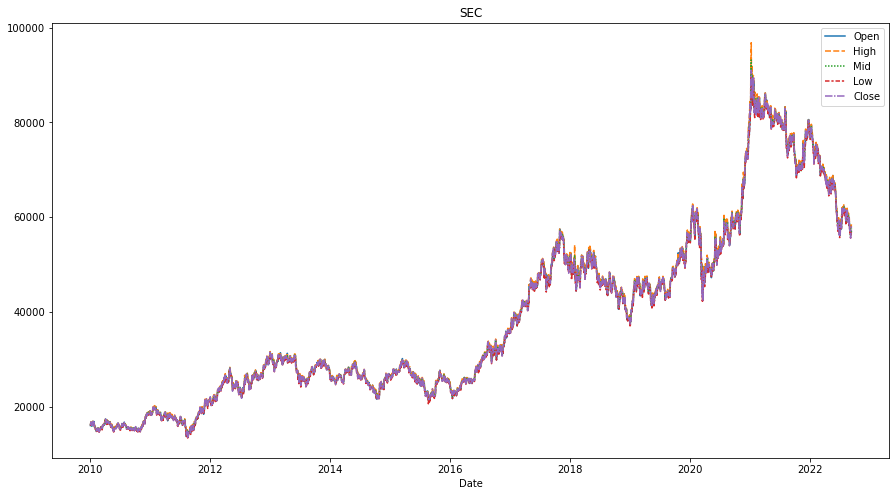

In [13]:
plt.figure(figsize = (15,8))
sns.lineplot(data = se[['Open', 'High','Mid','Low','Close']]).set(title = 'SEC')
plt.show()

In [14]:
se.shape

(3130, 9)

In [19]:
se_norm = se.Close.values.reshape(-1,1)
kospi_norm = kospi.Close.values.reshape(-1,1)
sp500_norm = sp500.Close.values.reshape(-1,1)

In [21]:
mmscaler = MinMaxScaler()

In [22]:
se_norm= mmscaler.fit_transform(se_norm)
kospi_norm = mmscaler.fit_transform(kospi_norm)
sp500_norm = mmscaler.fit_transform(sp500_norm)

In [24]:
se_norm

array([[0.03333333],
       [0.03669251],
       [0.04160207],
       ...,
       [0.54780362],
       [0.54263566],
       [0.5749354 ]])

In [25]:
kospi_norm

array([[0.12908848],
       [0.12610076],
       [0.13405713],
       ...,
       [0.49731267],
       [0.5015453 ],
       [0.53686737]])

In [26]:
sp500_norm

array([[0.02451522],
       [0.02925558],
       [0.03019094],
       ...,
       [0.80678224],
       [0.81818931],
       [0.77109839]])

In [27]:
dtw.dtw(se_norm,kospi_norm,keep_internals = 1).distance

99.51596393689918

KOSPI와 S&P의 Dynamic time warping & DTW distance

105.55060112299005


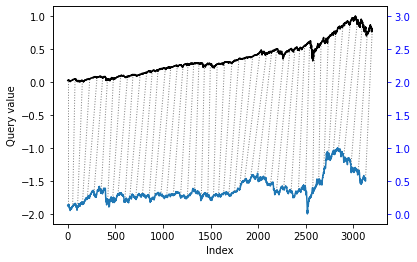

In [41]:
dtw.dtw(sp500_norm,kospi_norm,keep_internals = True,
        step_pattern = dtw.rabinerJuangStepPattern(6,'c')).plot(type = 'twoway',offset = -2)
print(dtw.dtw(sp500_norm,kospi_norm,keep_internals = True).distance)

S&P와 SEC의 Dynamic time warping & DTW distance

63.328568682959705


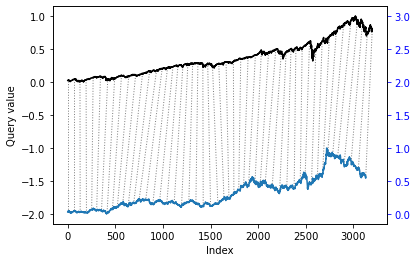

In [30]:
dtw.dtw(sp500_norm,se_norm,keep_internals = True,
        step_pattern = dtw.rabinerJuangStepPattern(6,'c')).plot(type = 'twoway',offset = -2)
print(dtw.dtw(sp500_norm,se_norm,keep_internals = True).distance)

SEC와 KOSPI의 Dynamic time warping & DTW distance

99.51596393689918


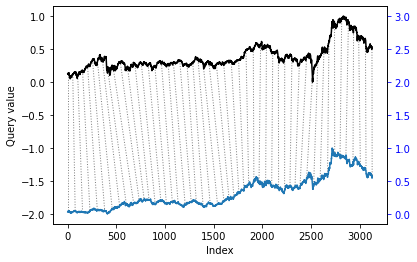

In [31]:
dtw.dtw(kospi_norm,se_norm,keep_internals = True,
        step_pattern = dtw.rabinerJuangStepPattern(6,'c')).plot(type = 'twoway',offset = -2)
print(dtw.dtw(kospi_norm,se_norm,keep_internals = True).distance)